## Blog Post

My writeup for this project is available at https://www.aaronkim.com/titanic/

---

In [204]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrices
import sqlite3
from pandas.io import sql
from sklearn import metrics
import sklearn.preprocessing as pre
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc

%matplotlib inline

## Pre-Task: Describe the goals of your study

## Part 1: Aquire the Data

In [205]:
#!psql -h dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com -p 5432 -U dsi_student titanic
#password:

# The above doesnt work, so the acceptable solution is to connect to the db via CLI, export to CSV
# then import the CSV. Solution approved by John Marin during lecture
sqlite_db = 'titanic_via_db.sqlite'
conn = sqlite3.connect(sqlite_db)

pd.read_csv('titanic_rmdb.csv').to_sql('titanic_rmdb',con=conn,if_exists='replace',index=False)

In [206]:
sql.read_sql('select * from titanic_rmdb limit 5', con=conn)

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


#### 1. Connect to the remote database

Please see Part 1

#### 2. Query the database and aggregate the data

In [207]:
titanic_rm = sql.read_sql('select * from titanic_rmdb', con=conn)

## Part 2: Exploratory Data Analysis

#### 1. Describe the Data

In [208]:
titanic_rm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
index          891 non-null int64
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [209]:
del titanic_rm['index']

In [210]:
titanic_rm.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')

In [211]:
ttn_age_train = titanic_rm[(titanic_rm['Age'].notnull())].reset_index()
del ttn_age_train['index']

In [212]:
ttn_age_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [213]:
titanic_rm['Title'] = [titanic_rm['Name'][ii].split(',')[1].split('.')[0].strip(' ') for ii in range(0,len(titanic_rm['Name']))]

In [214]:
ttn_age_mx = titanic_rm.groupby(['SibSp','Title'])['Age'].mean()

In [215]:
# impute age based on title and sibsp combined, or if sibsp unavailable then by title alone
new_ages=[]

for ii in range(0,len(titanic_rm)):
    if np.isnan(titanic_rm.iloc[ii]['Age']):
        if not np.isnan(ttn_age_mx[titanic_rm.iloc[ii]['SibSp']][titanic_rm.iloc[ii]['Title']]):
            titanic_rm.replace(titanic_rm.iloc[ii]['Age'], ttn_age_mx[titanic_rm.iloc[ii]['SibSp']][titanic_rm.iloc[ii]['Title']], inplace=True)
        else:
            titanic_rm.replace(titanic_rm.iloc[ii]['Age'], ttn_age_mx[0][titanic_rm.iloc[ii]['Title']], inplace=True)


In [216]:
titanic_rm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
Title          891 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


#### 2. Visualize the Data

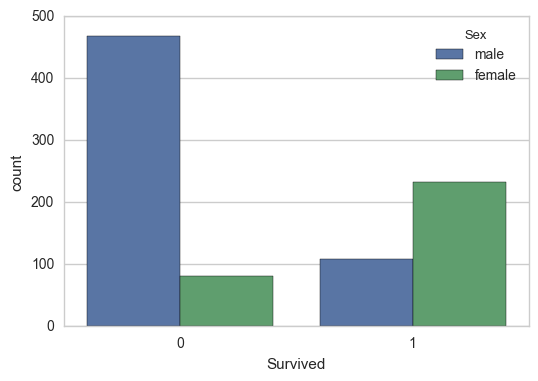

In [217]:
sns.countplot(x='Survived',hue='Sex',data=titanic_rm)

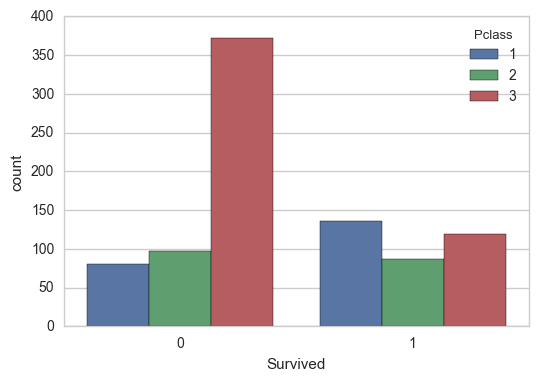

In [218]:
sns.countplot(x='Survived',hue='Pclass',data=titanic_rm)

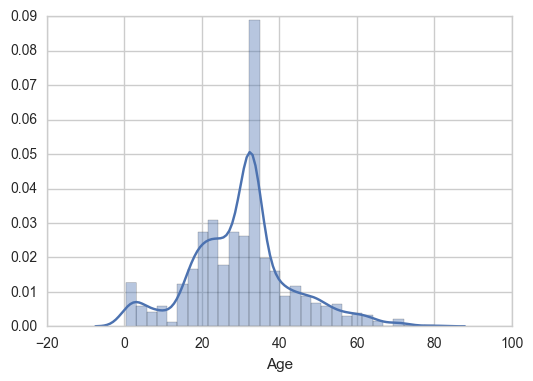

In [219]:
sns.distplot(titanic_rm['Age'])

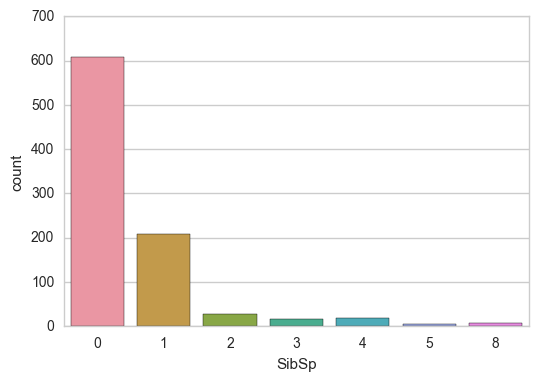

In [220]:
sns.countplot(x='SibSp',data=titanic_rm)

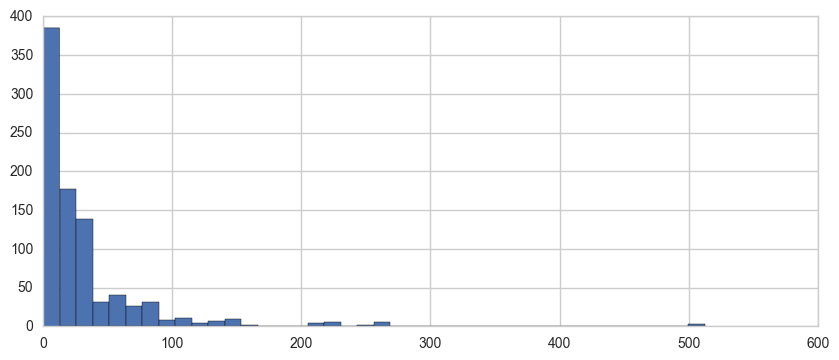

In [221]:
titanic_rm['Fare'].hist(bins=40,figsize=(10,4))

In [222]:
rmst_corr = titanic_rm.corr()

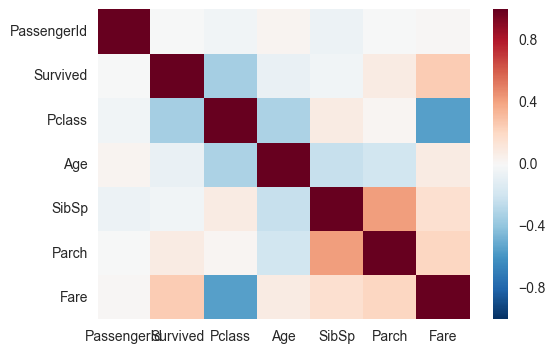

In [223]:
sns.heatmap(rmst_corr)

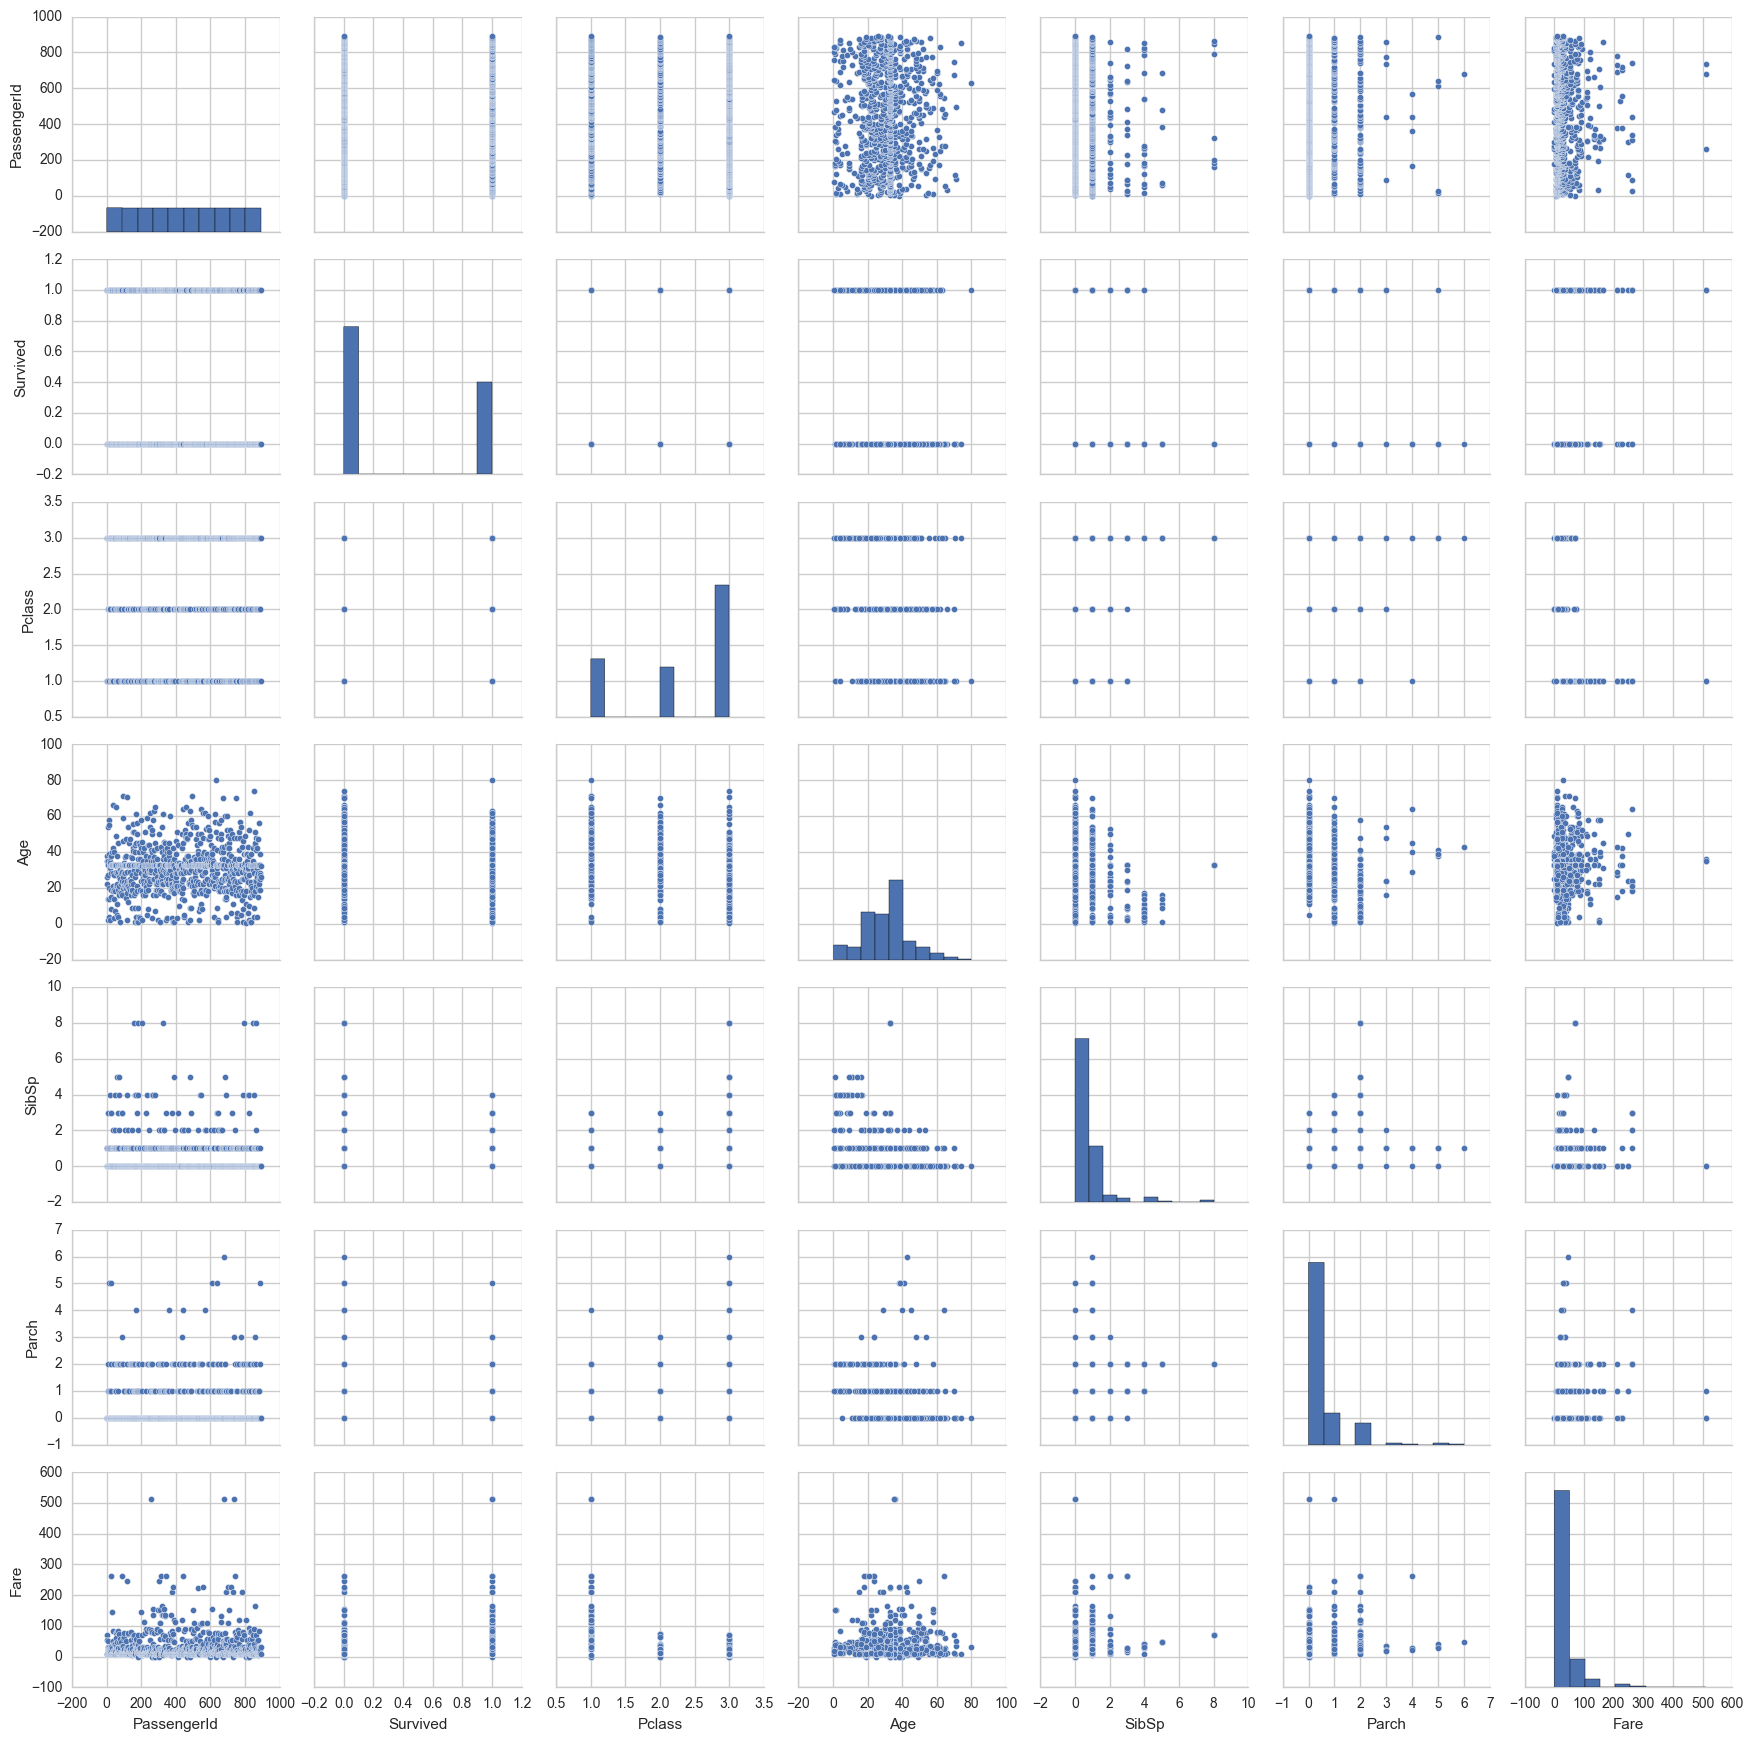

In [224]:
sns.pairplot(titanic_rm)

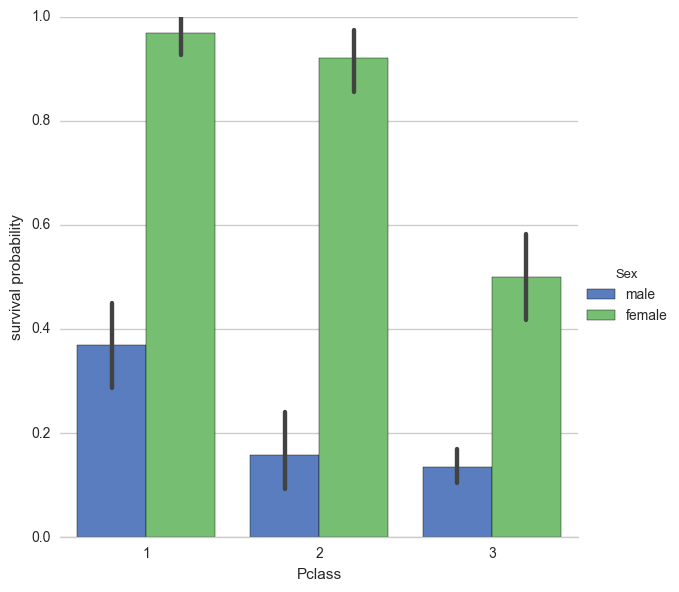

In [225]:
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=titanic_rm,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

## Part 3: Data Wrangling

#### 1. Create Dummy Variables for *Sex*  use sklearn pipeline

In [226]:
le = pre.LabelEncoder()
enc = pre.OneHotEncoder()

vs = le.fit_transform(titanic_rm['Sex'].values)
enc.fit(map(list, zip(vs)))
enc.transform(vs[0]).toarray()

array([[ 0.,  1.]])

In [227]:
s_dummies = pd.get_dummies(titanic_rm['Sex'],drop_first=True)
e_dummies = pd.get_dummies(titanic_rm['Embarked'],drop_first=True)

In [228]:
titanic_rm.drop(['PassengerId','Name','Ticket','Cabin','Title','Embarked','Sex'],axis=1,inplace=True)

In [229]:
titanic_train = pd.concat([titanic_rm,s_dummies,e_dummies],axis=1)

In [230]:
titanic_train.head(3)

,Survived,Pclass,Age,SibSp,Parch,Fare,male,C,Q,S
0,0,3,22.0,1,0,7.2500,1.0,0.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,0.0,1.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,0.0,0.0,0.0,1.0


## Part 4: Logistic Regression and Model Validation

#### 1. Define the variables that we will use in our classification analysis

In [231]:
# INITIAL FEATURE WRANGLING AND PREPROCESSING
# COLUMN 0 IS NOT RELEVANT, COLUMN 1 IS y, THE REST COMPRISE THE FEATURE MATRIX X
# GOAL IS BINARY FACTORS FOR THE y FOR THE LOGISTIC REGRESSION PREPARATION


y = titanic_rm["Survived"]

column_names_adj = ['Age',
                'male',
                'Pclass',
                'SibSp',
                'Parch']

X = titanic_train.loc[:, column_names_adj].values

# INSTANTIATE LABELENCODER CLASS
le = LabelEncoder()

#X = pd.concat([dummies, pd.DataFrame(X)], axis=1).fillna(0.0)

#### 2. Transform "Y" into a 1-Dimensional Array for SciKit-Learn

In [232]:
y = le.fit_transform(y)

#### 3. Conduct the logistic regression

In [233]:
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score

lr = LogisticRegression(penalty = 'l2', C=1)
lr.fit(X, y)

scores = cross_validation.cross_val_score(lr, X, y,scoring='accuracy', cv=10)

print('INITIAL MODEL ACCURACY (NO Cross Validation: ', lr.score(X, y))
print('CV 10-FOLD Scores: ', scores)
print('CV 10-FOLD Mean Accuracy', scores.mean() )
print('CV 10-FOLD Standard Deviation of Accuracy', scores.std() )

('INITIAL MODEL ACCURACY (NO Cross Validation: ', 0.80134680134680136)
('CV 10-FOLD Scores: ', array([ 0.81111111,  0.77777778,  0.7752809 ,  0.84269663,  0.80898876,
        0.78651685,  0.80898876,  0.74157303,  0.83146067,  0.78409091]))
('CV 10-FOLD Mean Accuracy', 0.7968485415957326)
('CV 10-FOLD Standard Deviation of Accuracy', 0.028199251274645246)


#### 4. Examine the coefficients

In [234]:
coef_df = pd.DataFrame(lr.coef_[0], column_names_adj,columns=['Coef'])

In [235]:
coef_df

,Coef
Age,-0.028430
male,-2.503264
Pclass,-0.958967
SibSp,-0.275931
Parch,-0.043413


#### 6. Test on a *Test* 

In [236]:
# Use Titanic Test data
titanic_test = pd.read_csv('test.csv')
titanic_test['Title'] = [titanic_test['Name'][ii].split(',')[1].split('.')[0].strip(' ') 
                       for ii in range(0,len(titanic_test['Name']))]

In [237]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs


In [238]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
Title          418 non-null object
dtypes: float64(2), int64(4), object(6)
memory usage: 39.3+ KB


In [239]:
# Age Imputation

for ii in range(0,len(titanic_test)):
    if np.isnan(titanic_test.iloc[ii]['Age']):
        if not np.isnan(ttn_age_mx[titanic_test.iloc[ii]['SibSp']][titanic_test.iloc[ii]['Title']]):
            titanic_test.replace(titanic_test.iloc[ii]['Age'], 
                                 ttn_age_mx[titanic_test.iloc[ii]['SibSp']][titanic_test.iloc[ii]['Title']], 
                                 inplace=True)
        else:
            titanic_test.replace(titanic_test.iloc[ii]['Age'], ttn_age_mx[0][titanic_test.iloc[ii]['Title']], 
                                 inplace=True)

In [240]:
s_dummies = pd.get_dummies(titanic_test['Sex'],drop_first=True)
e_dummies = pd.get_dummies(titanic_test['Embarked'],drop_first=True)

titanic_test.drop(['Name','Ticket','Cabin','Title','Embarked','Sex'],axis=1,inplace=True)


In [241]:
titanic_test = pd.concat([titanic_test,s_dummies,e_dummies],axis=1)

In [242]:
titanic_test.head(2)

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,892,3,34.5,0,0,7.8292,1.0,1.0,0.0
1,893,3,47.0,1,0,7.0000,0.0,0.0,1.0


In [243]:
titanic_test["Survived"] = 0
y_test = titanic_test["Survived"]

test_cols = ['Age',
                'male',
                'Pclass',
                'SibSp',
                'Parch']

X_test = titanic_test.loc[:, test_cols].values

# INSTANTIATE LABELENCODER CLASS
le = LabelEncoder()

In [244]:
y_pred = lr.predict(X_test)

#### 7. Predict the class labels for the *Test* set

See 4.11


#### 8. Predict the class probabilities for the *Test* set

In [245]:
lr.predict_proba(X_test)

array([[ 0.89629766,  0.10370234],
       [ 0.57072136,  0.42927864],
       [ 0.87864046,  0.12135954],
       [ 0.87473829,  0.12526171],
       [ 0.40551114,  0.59448886],
       [ 0.82834225,  0.17165775],
       [ 0.3835627 ,  0.6164373 ],
       [ 0.78167695,  0.21832305],
       [ 0.30669444,  0.69330556],
       [ 0.91091013,  0.08908987],
       [ 0.89144457,  0.10855543],
       [ 0.63778525,  0.36221475],
       [ 0.08984987,  0.91015013],
       [ 0.90754152,  0.09245848],
       [ 0.16340085,  0.83659915],
       [ 0.20947844,  0.79052156],
       [ 0.77065198,  0.22934802],
       [ 0.85482252,  0.14517748],
       [ 0.42951897,  0.57048103],
       [ 0.48800309,  0.51199691],
       [ 0.74980438,  0.25019562],
       [ 0.81384406,  0.18615594],
       [ 0.08983791,  0.91016209],
       [ 0.47462578,  0.52537422],
       [ 0.18626407,  0.81373593],
       [ 0.94651323,  0.05348677],
       [ 0.07067162,  0.92932838],
       [ 0.86003522,  0.13996478],
       [ 0.60434728,

#### 10. Cross validate on 10 folds

See section 4.3

#### 11. Check the Classification Report

In [246]:
from sklearn.metrics import confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

prediction = lr.predict(X_test)

print classification_report(y_test, prediction)

             precision    recall  f1-score   support

          0       0.82      0.88      0.85       157
          1       0.81      0.72      0.76       111

avg / total       0.81      0.81      0.81       268



#### 12. What do the classification metrics tell us?

#### 13. Check the Confusion Matrix

In [247]:
print confusion_matrix(y_test, prediction)

[[138  19]
 [ 31  80]]


#### 14. What does the Confusion Matrix tell us? 

#### 15. Plot the ROC curve

In [108]:
#!pip install ggplot

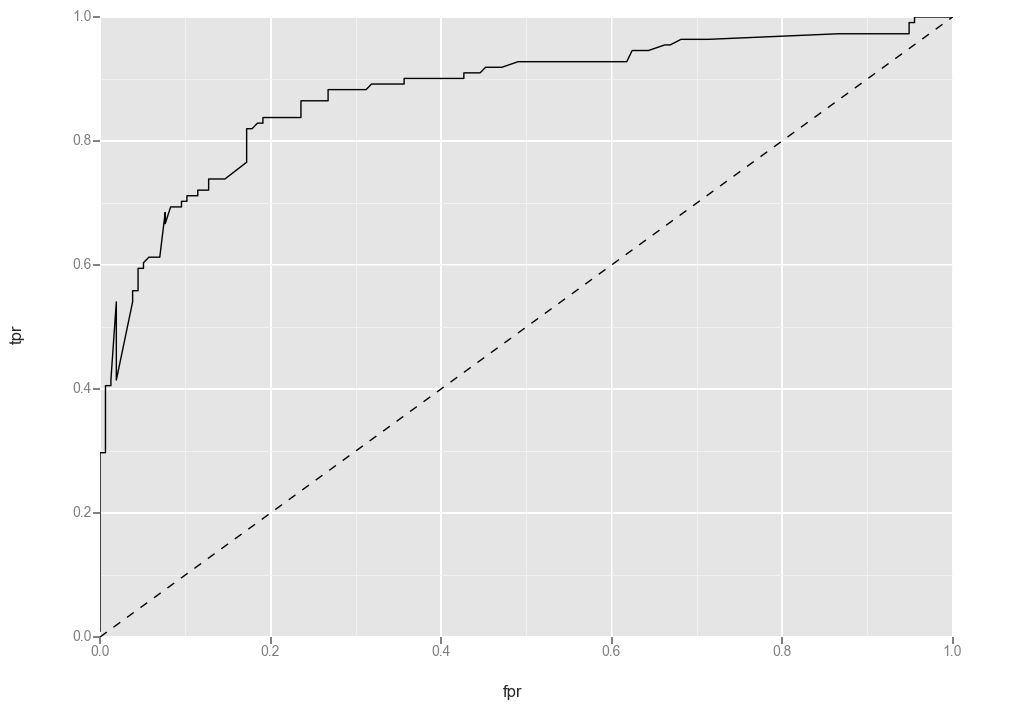

<ggplot: (319138705)>

In [248]:
from ggplot import *

preds = lr.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')

#### 16. What does the ROC curve tell us?

ROC curves is a visualization of the tradeoff between sensitivity and specificity. Seeing as how the curve tends to hug the left-hand border and then the top border of the ROC space, this test can be considered more on the accurate side.

## Part 5: Gridsearch

#### 1. Use GridSearchCV with logistic regression to search for optimal parameters 

- Use the provided parameter grid. Feel free to add if you like (such as n_jobs).
- Use 5-fold cross-validation.

In [249]:
from sklearn.grid_search import GridSearchCV

clf = GridSearchCV(LogisticRegression(class_weight='balanced'),
                   {"C":[0.01,0.1,1.0,10.0,100.0, 1000]},
                   n_jobs=-1
                  )

In [250]:
clf.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

#### 2. Print out the best parameters and best score. Are they better than the vanilla logistic regression?

In [251]:
clf.best_estimator_

LogisticRegression(C=1000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [252]:
clf.best_params_

{'C': 1000}

#### 3. Explain the difference between the difference between the L1 (Lasso) and L2 (Ridge) penalties on the model coefficients.

L1 - can quickly reduce coefficients to zero, eliminating the feature

L2 - slower to reduce coefficients to zero, good when high degree of multicolinearity

#### 4. What hypothetical situations are the Ridge and Lasso penalties useful?

Ridge penalties are useful when the dataset has many variables that are colinear.

Lasso penalties are useful when you need to quickly select features.

#### 5. Explain how the regularization strength (C) modifies the regression loss function. Why do the Ridge and Lasso penalties have their respective effects on the coefficients?

Smaller C values specify stronger regularization. The penalties help reduce the potential tendancy of a model to overfit on the training data. 

#### 6.a. You decide that you want to minimize false positives. Use the predicted probabilities from the model to set your threshold for labeling the positive class to need at least 90% confidence. How and why does this affect your confusion matrix?

In [ ]:
# can set the threshold with the following
# y_pred_thresh = [1 if x <= 0.20 else 0 for x in y_pred_prob.T[0]]


## Part 6: Gridsearch and kNN

#### 1. Perform Gridsearch for the same classification problem as above, but use KNeighborsClassifier as your estimator

At least have number of neighbors and weights in your parameters dictionary.

In [253]:
# TUNE THE MODEL USING AUTOMATED GRID SEARCH VIA 'LogisticRegressionCV' - NOTE GridSearchCV has been implemented
# below since LogisticRegressionCV has been deprecated

import patsy

knn_clf = KNeighborsClassifier(metric = 'euclidean', n_jobs =-1)

knn_p = Pipeline([ ('scl', StandardScaler()), ('clf', knn_clf)])

model_def = "Survived ~ Age + male + Pclass + SibSp + Parch"

yk_train, Xk_train = patsy.dmatrices(model_def, data=titanic_train, return_type='dataframe')
yk_train = yk_train.values.ravel()

neighbors = range(1,10)

knn_param = {
    'clf__n_neighbors':neighbors,
    'clf__weights':['uniform','distance']}

gt = GridSearchCV(estimator=knn_p, param_grid=knn_param,scoring='accuracy', cv=10, n_jobs=-1)

# PERFORM GRIDSEARCH
gt = gt.fit(X, y)

#### 2. Print the best parameters and score for the gridsearched kNN model. How does it compare to the logistic regression model?

In [254]:
print('Grid Search Best Score: %.4f' % gt.best_score_)
print('Grid Search Best Parameter for C: ')
print gt.best_params_

Grid Search Best Score: 0.8182
Grid Search Best Parameter for C: 
{'clf__weights': 'uniform', 'clf__n_neighbors': 3}


#### 3. How does the number of neighbors affect the bias-variance tradeoff of your model?

#### Why?

#### 4. In what hypothetical scenario(s) might you prefer logistic regression over kNN, aside from model performance metrics?

#### 5. Fit a new kNN model with the optimal parameters found in gridsearch. 

In [255]:
knn_clf2 = KNeighborsClassifier(metric = 'euclidean', n_jobs =-1, n_neighbors=3, weights='uniform')

#### 6. Construct the confusion matrix for the optimal kNN model. Is it different from the logistic regression model? If so, how?

In [256]:
knn_clf2.fit(X,y)

knn_prediction = knn_clf2.predict(X_test)

print classification_report(y_test, knn_prediction)

             precision    recall  f1-score   support

          0       0.86      0.93      0.89       157
          1       0.89      0.78      0.83       111

avg / total       0.87      0.87      0.87       268



In [257]:
print confusion_matrix(y_test, knn_prediction)

[[146  11]
 [ 24  87]]


#### 7. Plot the ROC curves for the optimized logistic regression model and the optimized kNN model on the same plot.

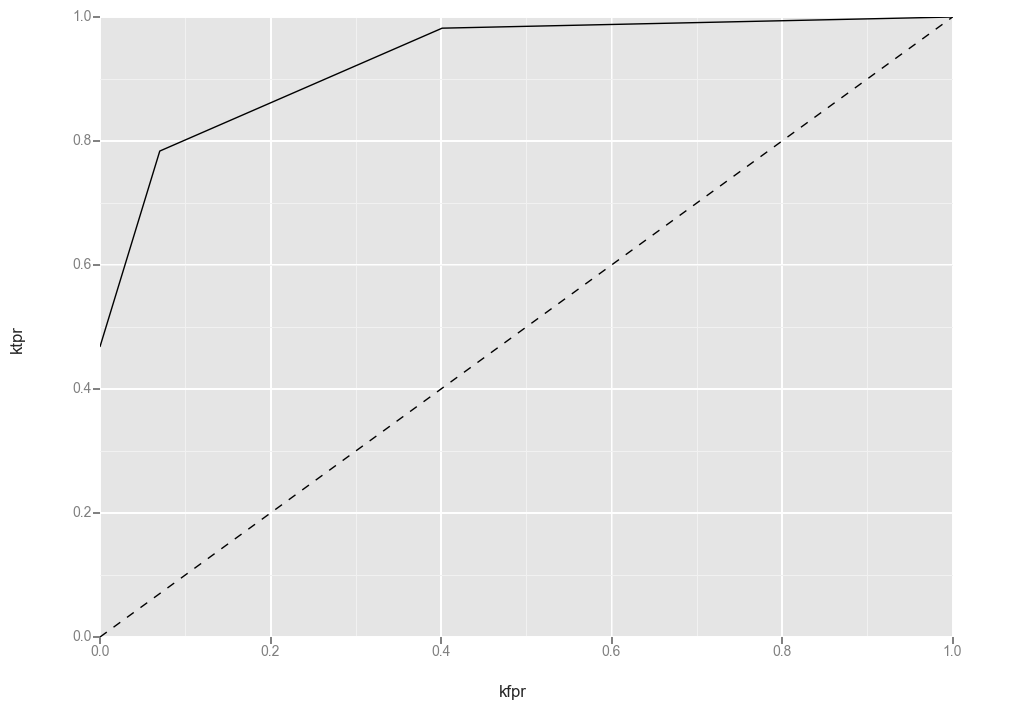

<ggplot: (324184305)>

In [258]:
knn_preds = knn_clf2.predict_proba(X_test)[:,1]
kfpr, ktpr, _ = metrics.roc_curve(y_test, knn_preds)

df = pd.DataFrame(dict(fpr=kfpr, tpr=ktpr))
ggplot(df, aes(x='kfpr', y='ktpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')

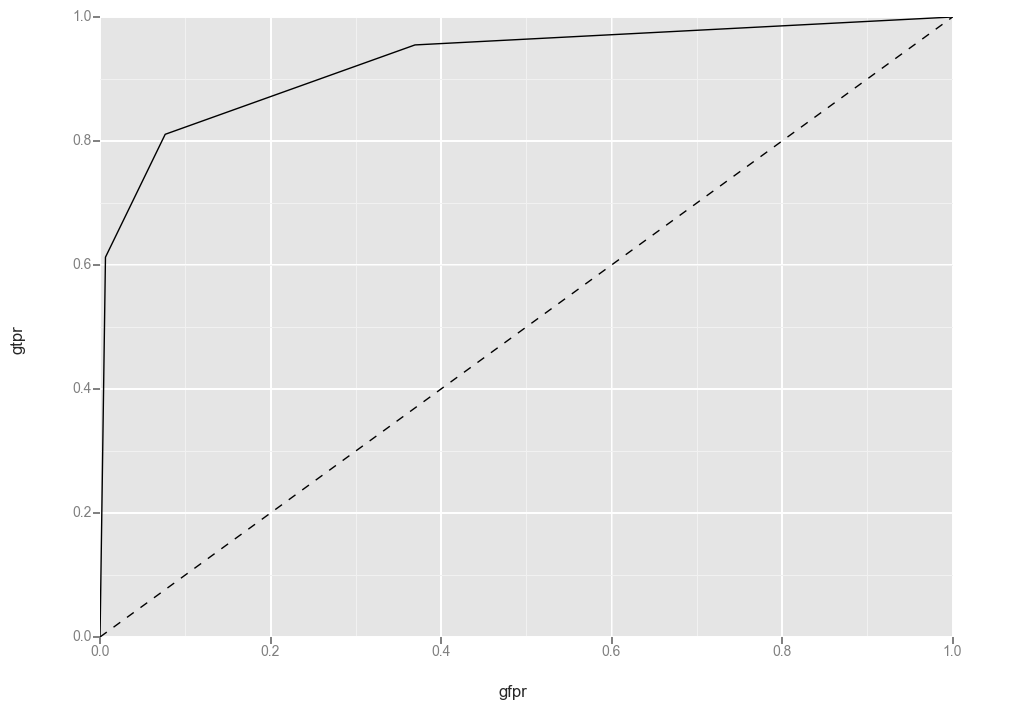

<ggplot: (322231833)>

In [259]:
gt_preds = gt.predict_proba(X_test)[:,1]
gfpr, gtpr, _ = metrics.roc_curve(y_test, gt_preds)

df = pd.DataFrame(dict(fpr=gfpr, tpr=gtpr))
ggplot(df, aes(x='gfpr', y='gtpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')

## Part 7: Precision-recall

#### 1. Gridsearch the same parameters for logistic regression but change the scoring function to 'average_precision'

`'average_precision'` will optimize parameters for area under the precision-recall curve instead of for accuracy.

In [260]:
pipe_lr = Pipeline([ ('scl', StandardScaler()), ('clf', LogisticRegression(random_state=1)) ])
pipe_lr.fit(X, y)

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range}]

gt = GridSearchCV(estimator=pipe_lr, param_grid=param_grid, scoring='average_precision', cv=10,n_jobs=-1)

gt = gt.fit(X, y)
print('Grid Search Best Score: %.4f' % gt.best_score_)
print('Grid Search Best Parameter for C: ')
print gt.best_params_

Grid Search Best Score: 0.8215
Grid Search Best Parameter for C: 
{'clf__C': 1.0}


#### 2. Examine the best parameters and score. Are they different than the logistic regression gridsearch in part 5?

See Part 7.1. 

#### 3. Create the confusion matrix. Is it different than when you optimized for the accuracy? If so, why would this be?

In [261]:
new_pred = gt.predict(X_test)

In [262]:
confusion_matrix(y_test, new_pred)

array([[139,  18],
       [ 29,  82]])

In [263]:
print classification_report(y_test, new_pred)

             precision    recall  f1-score   support

          0       0.83      0.89      0.86       157
          1       0.82      0.74      0.78       111

avg / total       0.82      0.82      0.82       268



The resulting confusion matrix when optimized for accuracy varied slightly compared to the previous confusion matrix based on the results of Logistic Regression. 

This could possibly be a result of overfitting.

#### 4. Plot the precision-recall curve. What does this tell us as opposed to the ROC curve?

[See the sklearn plotting example here.](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

In [264]:
from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

lw = 2

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

In [265]:
# Add noisy features
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=random_state)

In [266]:
# Run classifier
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

In [267]:
# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")

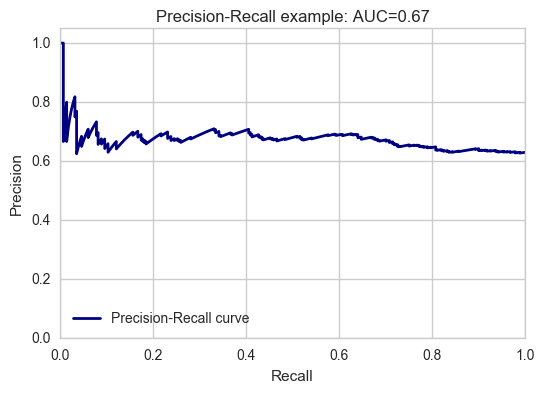

In [268]:
# Plot Precision-Recall curve
plt.clf()
plt.plot(recall[0], precision[0], lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
plt.legend(loc="lower left")
plt.show()

TypeError: zip argument #2 must support iteration

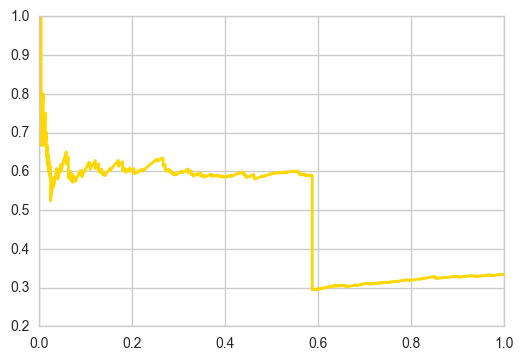

In [269]:
# Plot Precision-Recall curve for each class
plt.clf()
plt.plot(recall["micro"], precision["micro"], color='gold', lw=lw,
         label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=lw,
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(i, average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
plt.show()